In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import skew as skew
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from  sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
import itertools

pd.options.display.max_columns = None

In [2]:
data = pd.read_csv('train.csv')
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(" ","_")

In [3]:
data.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

## Exploring/Understanding data

In [4]:
data.info()

#Many categorical
#Some columns have too many Nulls, we might need to delete those.
#If we convert string columns to int columns we might get more insights. But that can be the last thing we do.
#Looks like basement have some incoherencies.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [5]:
#Verifying columns with Nans

#How to treat nulls (nan)
#  *lotfrontage Nulls -> 0
#  *alley Nulls -> More than 1000 nans [Drop]
#  *masvnrtype/area -> None Masonry veneer [Ok]
#  *bsmtqual/bsmtcond/bsmtexposure/bsmtfintype1/BsmtFinType2 -> No Basement [0k]
#  *electrical -> Cannot replace [Drop]
#  *fireplacequ -> No fireplaces [Ok]
#  *'garagetype' ,'garageyrblt', 'garagefinish', 'garagequal', 'garagecond' -> No Garage [OK]
#  *poolqc -> More than 1000 nans [Drop]
#  *fence -> More than 1000 nans [Drop]
#  *miscfeature -> More than 1000 nans [Drop]

#Poolqc is related to Pool Area but we can keep pool area and drop poolqc.
#miscfeature isn't realted with anything is just an 'extra' and has lots of na.
#Alley isn't related to anything we can drop that withour problem
#lotfrontage have many nulls and isn't related to other var. Maybe we can drop that

#This ^ was concluded after verifying the columns and reading the 'data_description.txt' 

# LET'S EXPLORE 'saleprice'

## How is distributed?

In [6]:
saleprice = data['saleprice']

C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='saleprice', ylabel='Density'>

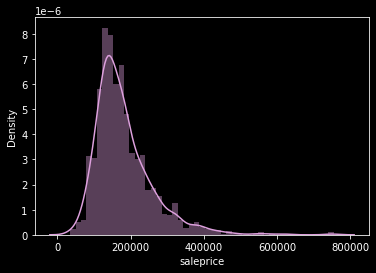

In [7]:
plt.style.use('dark_background')
sns.distplot(saleprice, color='plum')

It might look like a normal, but is not.
Seems like our data es skewed. 

 Did they gifted a house? :00


In [8]:
saleprice.min()

34900

Nope :c

# Correlation between variables

In [9]:
most_corr = data.corr()['saleprice'].sort_values(ascending=False)
most_corr.drop(['garagearea'], inplace=True)
most_corr_columns =most_corr[most_corr > .5].index.to_list()
display(most_corr_columns)

['saleprice',
 'overallqual',
 'grlivarea',
 'garagecars',
 'totalbsmtsf',
 '1stflrsf',
 'fullbath',
 'totrmsabvgrd',
 'yearbuilt',
 'yearremodadd']

## How does this look visually?

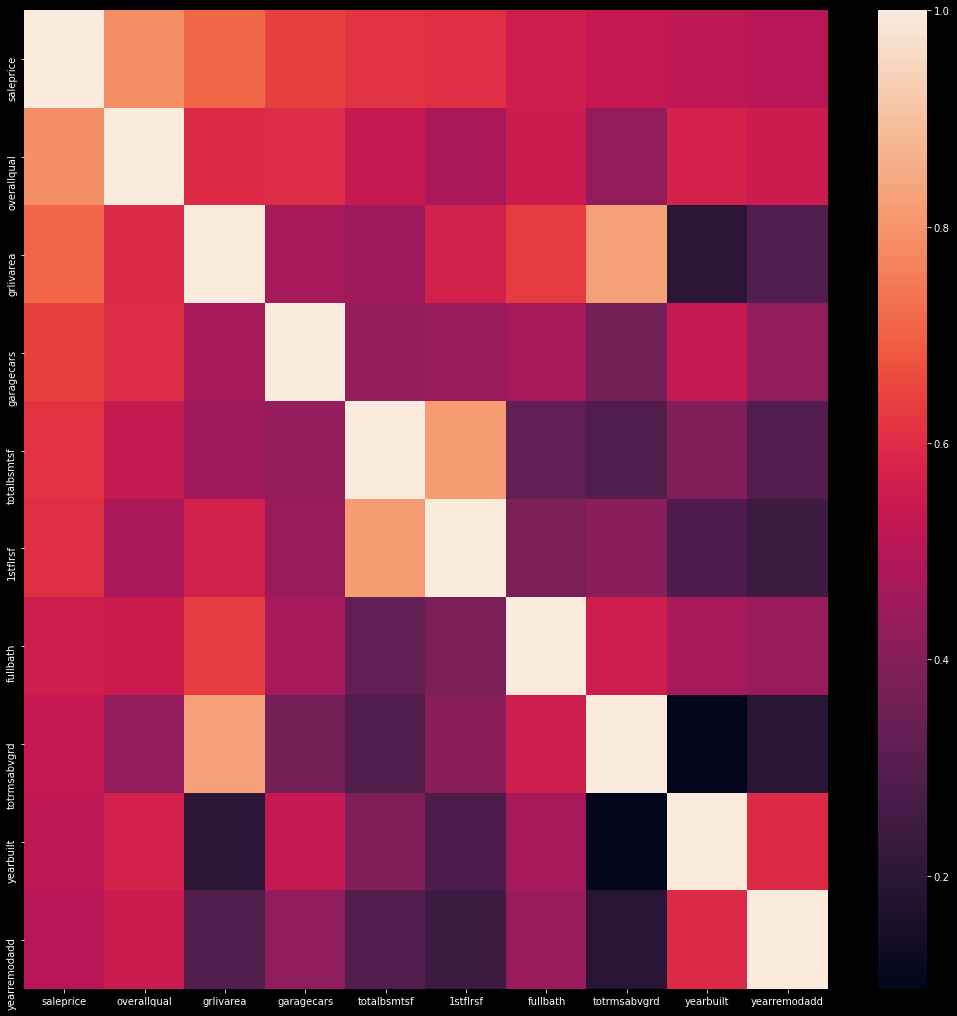

In [10]:
fig, heatmap = plt.subplots(figsize = (18,18))
corr =  data[most_corr_columns].corr()
hm = sns.heatmap(corr)
plt.show()

#### With this visualization i can confirm my comments from before.

## Visualizing correlated data 2.0

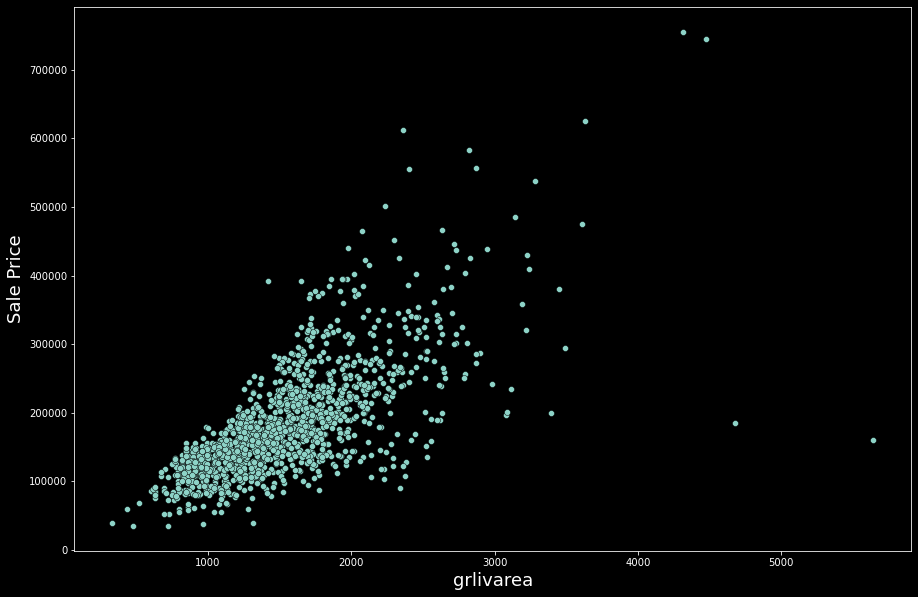

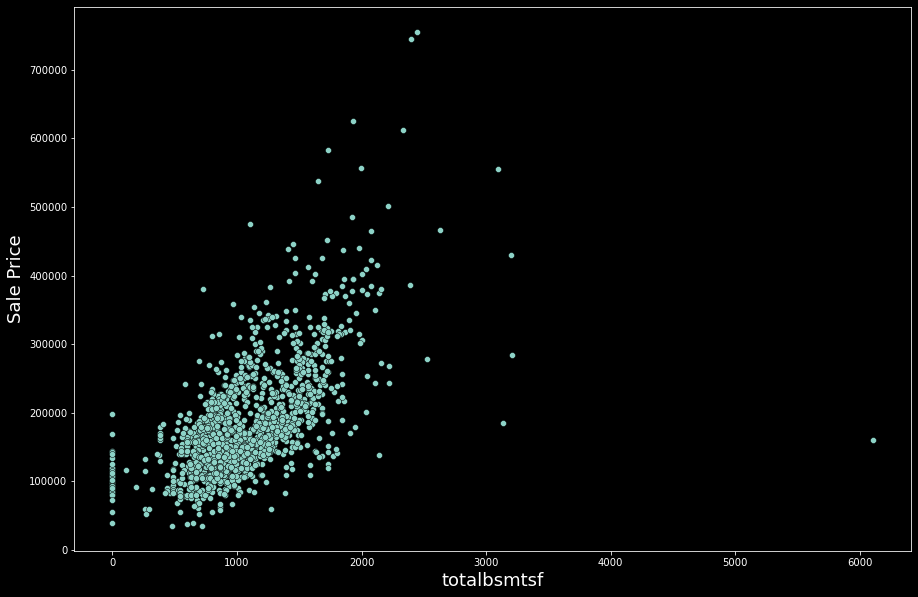

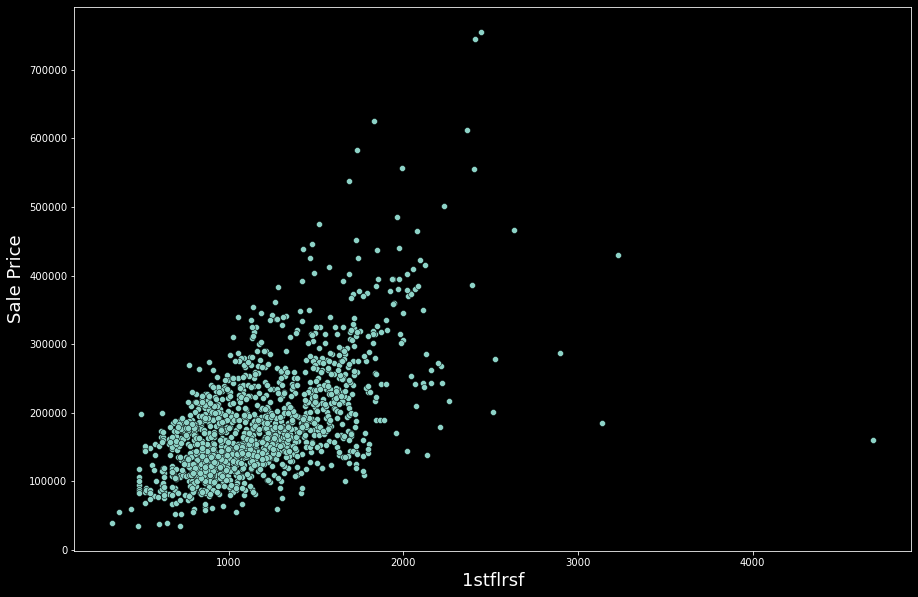

In [11]:
columns = ['grlivarea','totalbsmtsf', '1stflrsf']

for col in columns:
    fig, scatter = plt.subplots(figsize = (15,10))
    scatter = sns.scatterplot(x=data[col], y=saleprice, ec = 'black')
    scatter.set_xlabel(col, fontsize = 18)
    scatter.set_ylabel ('Sale Price', fontsize = 18)

Note: 
 * grlivearea have 2 outliers [> 4000] and price < 200,000
 * totalbsmtsf havee 1 [> 6000] and price < 200,000
 * 1stflrsf 1 [> 4000] and price < 200,000

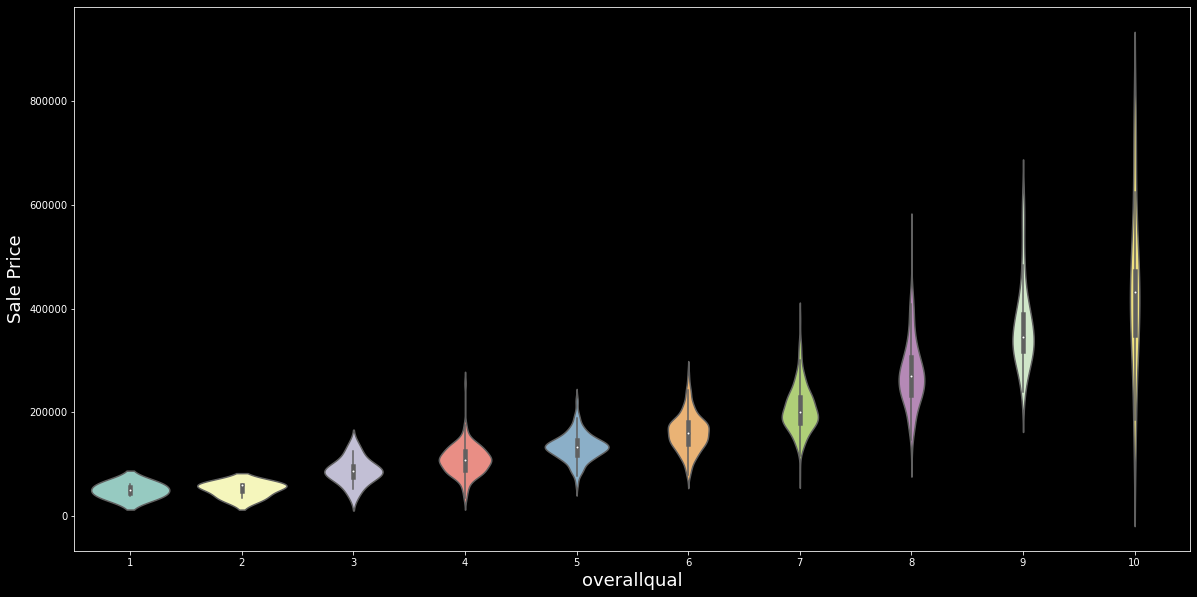

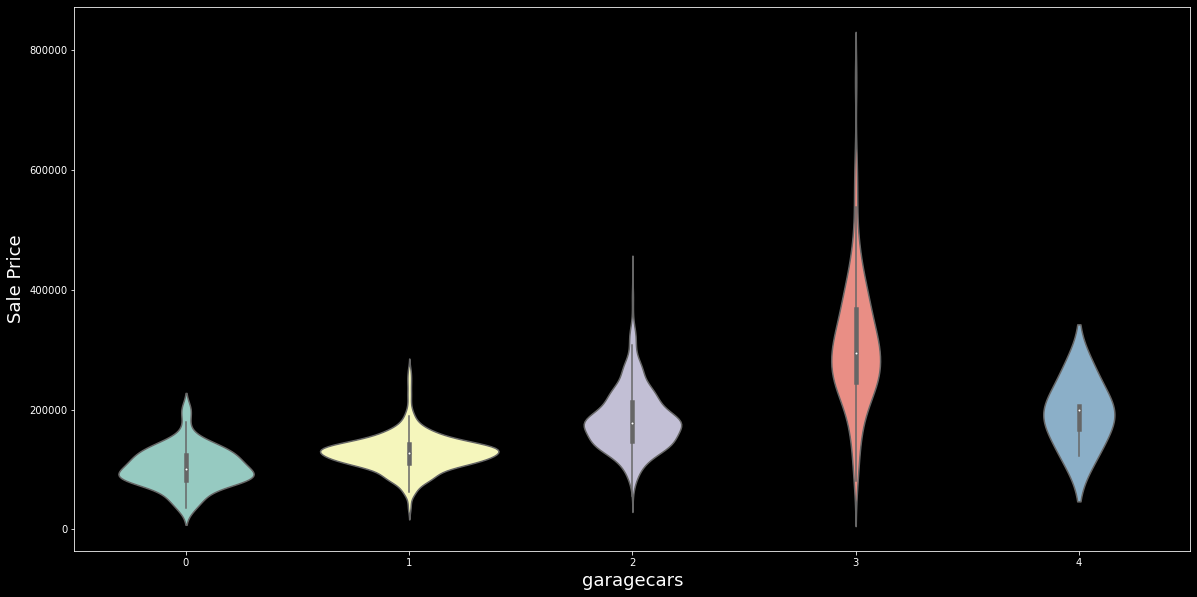

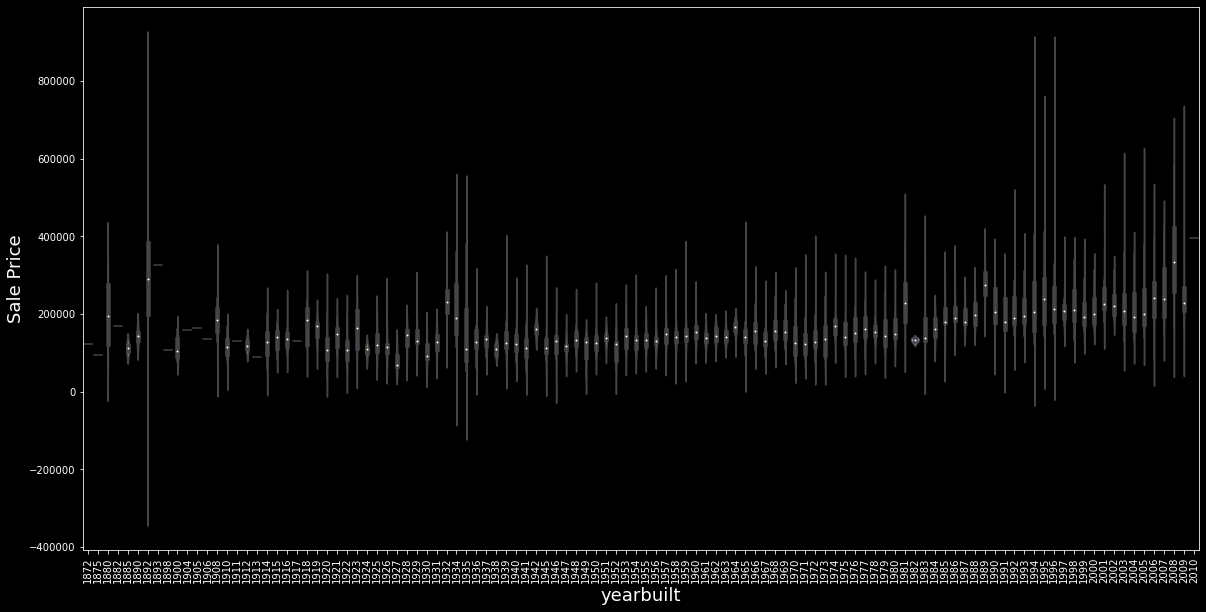

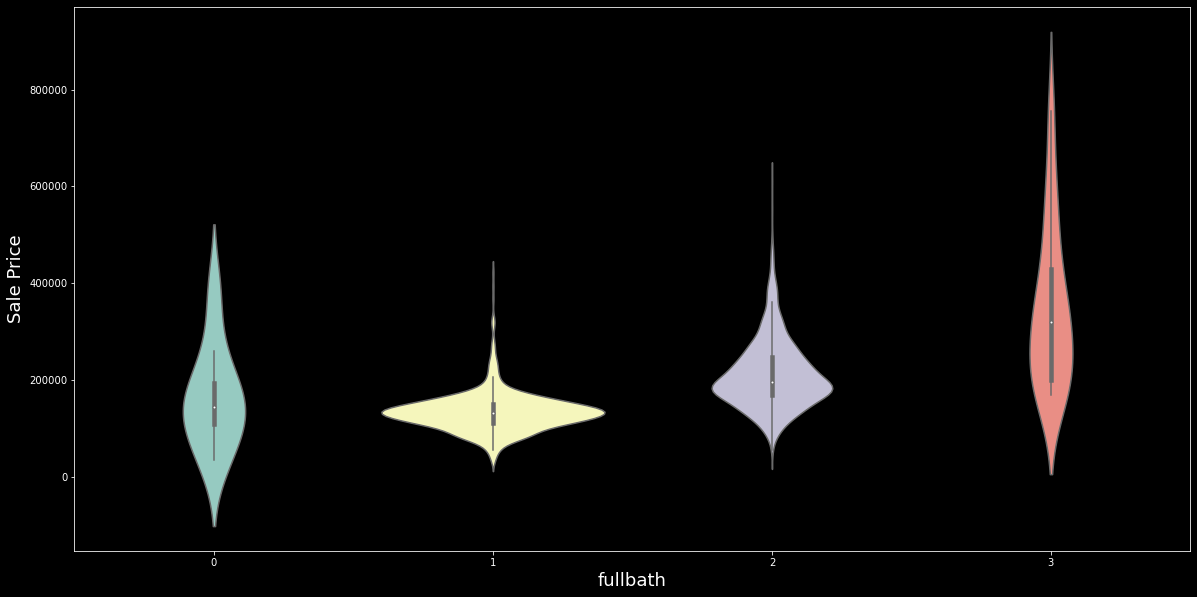

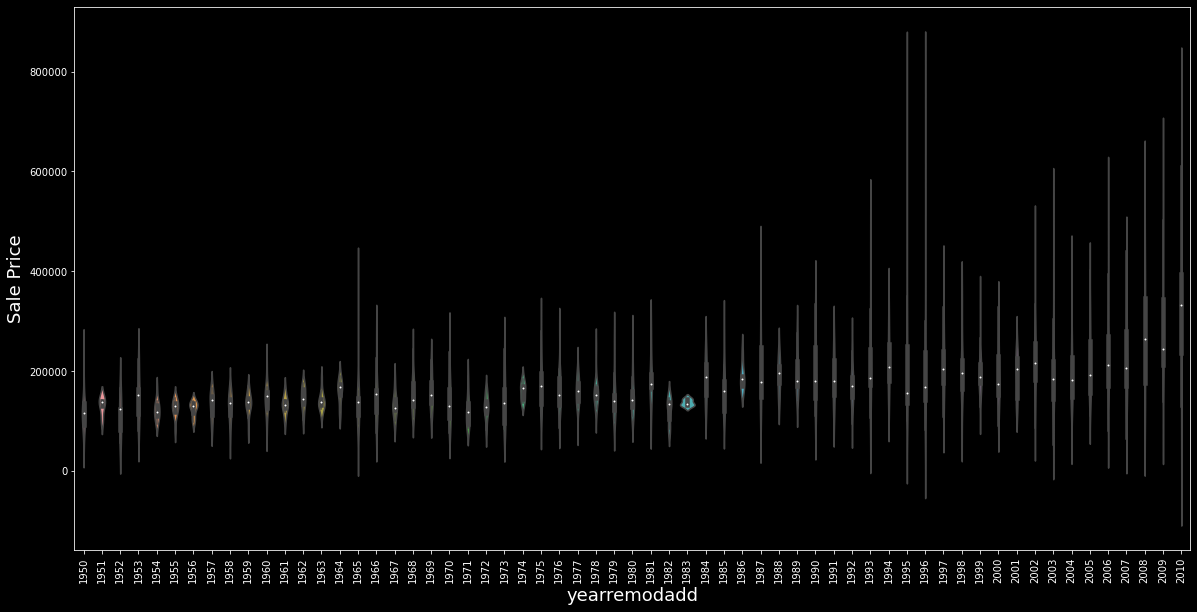

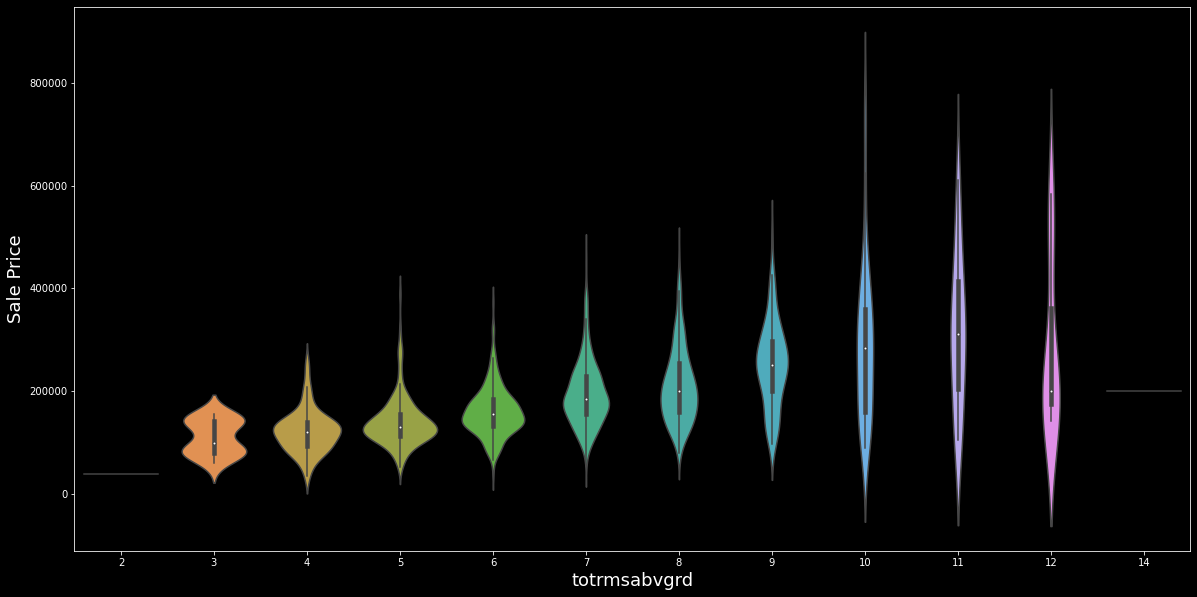

In [12]:
columns = ['overallqual','garagecars','yearbuilt','fullbath','yearremodadd', 'totrmsabvgrd']

for col in columns:
    fig, scatter = plt.subplots(figsize = (20,10))
    scatter = sns.violinplot(x=data[col], y=saleprice, ec = 'black')
    scatter.set_xlabel(col, fontsize = 18)
    scatter.set_ylabel ('Sale Price', fontsize = 18)
    if 'year' in col:
        for item in scatter.get_xticklabels():
            item.set_rotation(90)

--------

# CLEANING DATA

### Let's see how many missing data we have

In [13]:
missing_data = data.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data >= 1]
missing_data

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
bsmtexposure      38
bsmtfintype2      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrarea         8
masvnrtype         8
electrical         1
dtype: int64

In [14]:
#Dropping columns with more than 100 nan
cols_to_drop = missing_data[missing_data > 100].index.to_list() #list with the names of cols with more than 100 nan

#Creating 'Clean DF'
data_clean = data.drop(cols_to_drop, axis = 1) 

In [15]:
#Remaining  columns with more than 1 nan
missing_data = data_clean.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data >= 1]
missing_data

garagetype      81
garageyrblt     81
garagefinish    81
garagecond      81
garagequal      81
bsmtexposure    38
bsmtfintype2    38
bsmtfintype1    37
bsmtcond        37
bsmtqual        37
masvnrtype       8
masvnrarea       8
electrical       1
dtype: int64

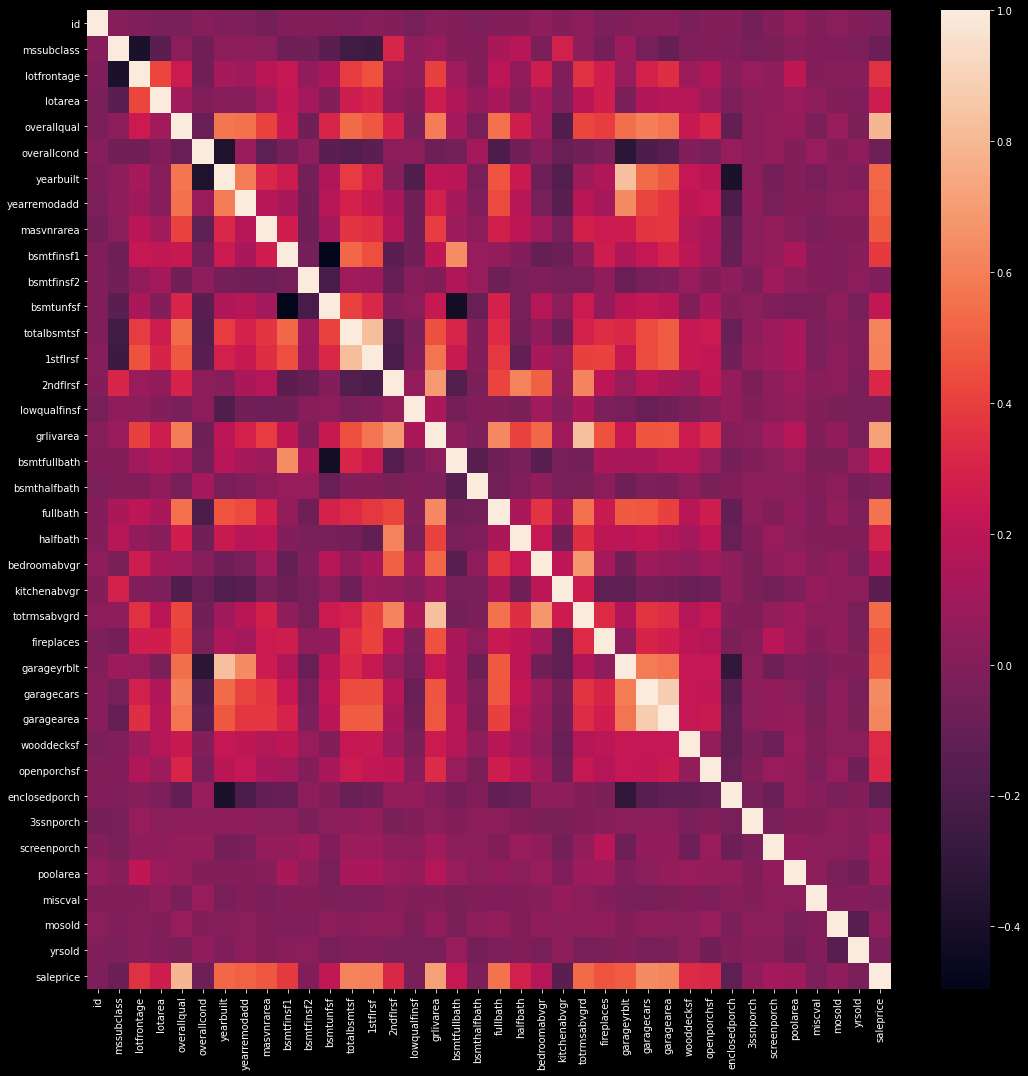

In [16]:
#Heatmap to get info about variables and know if i cand drop them or not.

fig, heatmap = plt.subplots(figsize = (18,18))
corr =  data.corr()
hm = sns.heatmap(corr)
plt.show()

* Garagecond,type,rblt,finish,qual aren't that related to the saleprice. We can keep the most related of the garages that is garagecars, we can drop the rest.<br>


* BSMT fintyp2,exposure,fintype1,cond,qual aren't that related to  saleprice, totalbsmtsf is more related to saleprice than all of those and a bigger basement is more important than all other caracteristics<br>


* masvnrtype,area aren't that related to saleprice. and masvnrarea  have a strong correlation with yearbuilt that we already had contemplated<br>


* Electricity is 1 just 1 record, we can drop that record.

##  Removing columns and record

In [17]:
#Droppping columns except electricity
data_clean.drop(missing_data.index.to_list()[:-1], axis = 1, inplace=True)

#Dropping that 1 electrical record
data_clean.drop(data_clean.loc[data['electrical'].isnull()].index, inplace=True)

# Outliers

In [18]:
#Note: 
# * grlivearea have 2 outliers [> 4000] and price < 200,000
# * totalbsmtsf havee 1 [> 6000] and price < 200,000
# * 1stflrsf 1 [> 4000] and price < 200,000


display(data_clean[(data_clean['grlivarea'] > 4000) & (data_clean['saleprice'] < 200000)])
display(data_clean[(data_clean['totalbsmtsf'] > 4000) & (data_clean['saleprice'] < 200000)])
display(data_clean[(data_clean['1stflrsf'] > 4000) & (data_clean['saleprice'] < 200000)])
#Uhh nice, they share the same reg

#creating list with index of outliers
outliers = data_clean[(data_clean['grlivarea'] > 4000) & (data_clean['saleprice'] < 200000)].index.to_list()
outliers

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,exterqual,extercond,foundation,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagecars,garagearea,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Ex,TA,PConc,2260,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,3,884,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Ex,TA,PConc,5644,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,2,1418,Y,214,292,0,0,0,480,0,1,2008,New,Partial,160000


,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,exterqual,extercond,foundation,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagecars,garagearea,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Ex,TA,PConc,5644,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,2,1418,Y,214,292,0,0,0,480,0,1,2008,New,Partial,160000


,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,exterqual,extercond,foundation,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagecars,garagearea,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Ex,TA,PConc,5644,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,2,1418,Y,214,292,0,0,0,480,0,1,2008,New,Partial,160000


[523, 1298]

### Droping outliers

In [19]:
for ix in outliers:
    data_clean.drop(ix, inplace=True)

## Verifying if we still have those outliers 

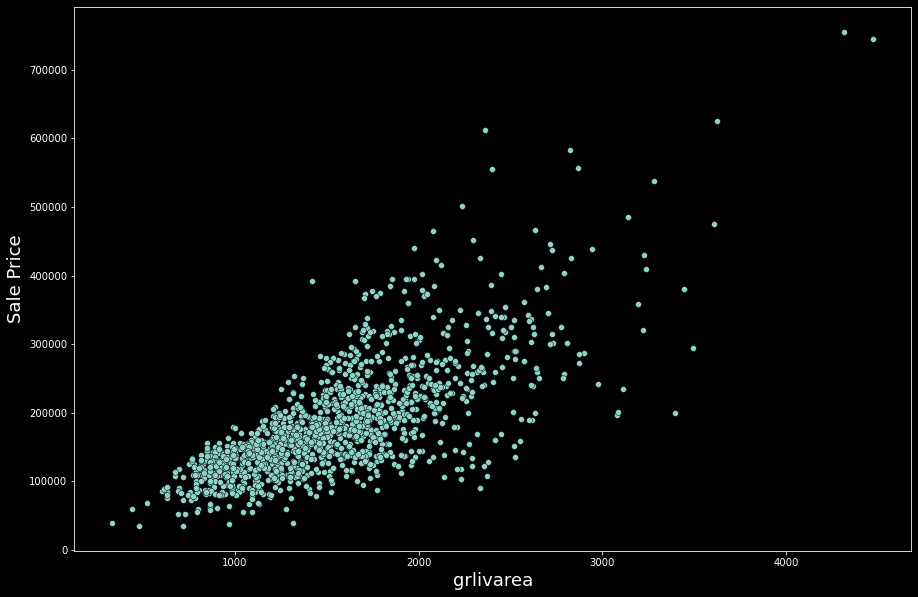

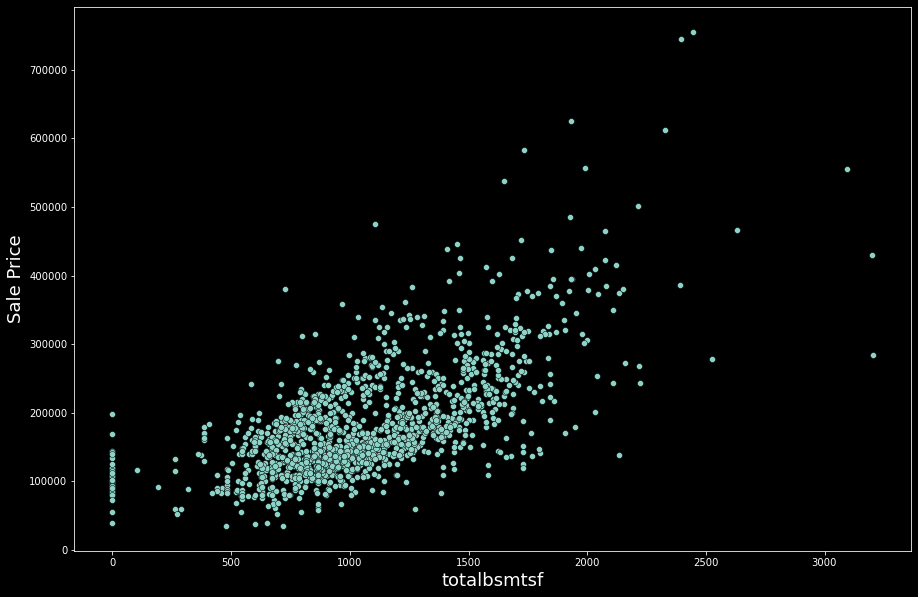

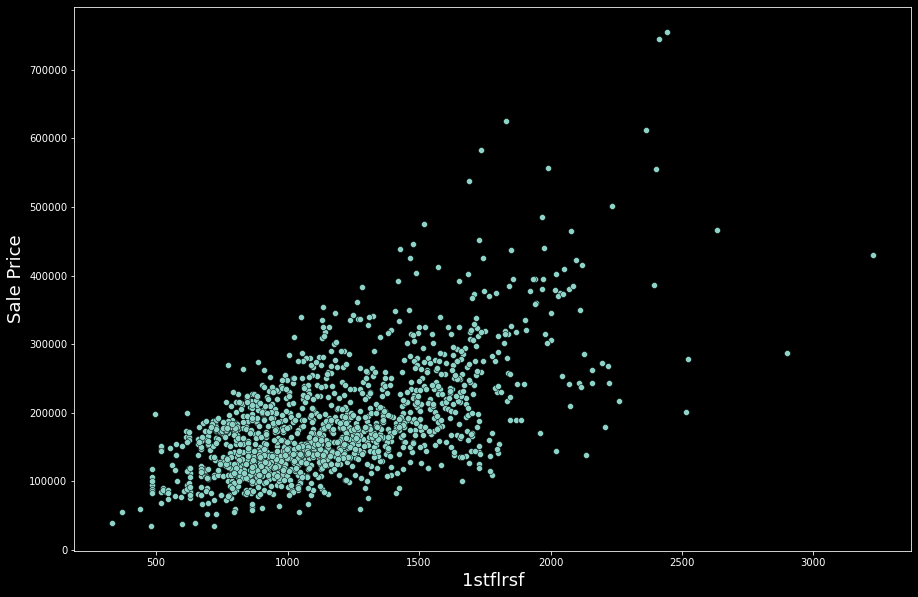

In [20]:
columns = ['grlivarea','totalbsmtsf', '1stflrsf']

for col in columns:
    fig, scatter = plt.subplots(figsize = (15,10))
    scatter = sns.scatterplot(x=data_clean[col], y=data_clean['saleprice'], ec = 'black')
    scatter.set_xlabel(col, fontsize = 18)
    scatter.set_ylabel ('Sale Price', fontsize = 18)

We are ok

In [21]:
#Creating DF only with columns that have correlation with saleprice
data_corr= data_clean[[*most_corr_columns]]
data_corr.set_index(data_clean['id'],inplace=True)
data_corr

,saleprice,overallqual,grlivarea,garagecars,totalbsmtsf,1stflrsf,fullbath,totrmsabvgrd,yearbuilt,yearremodadd
id,,,,,,,,,,
1,208500,7,1710,2,856,856,2,8,2003,2003
2,181500,6,1262,2,1262,1262,2,6,1976,1976
3,223500,7,1786,2,920,920,2,6,2001,2002
4,140000,7,1717,3,756,961,1,7,1915,1970
5,250000,8,2198,3,1145,1145,2,9,2000,2000
...,...,...,...,...,...,...,...,...,...,...
1456,175000,6,1647,2,953,953,2,7,1999,2000
1457,210000,6,2073,2,1542,2073,2,7,1978,1988
1458,266500,7,2340,1,1152,1188,2,9,1941,2006


# Plotting and verifying skewness of our data

In [22]:
data_adjusted = data_corr.copy()

In [23]:
for col in ['saleprice','grlivarea', 'totalbsmtsf','1stflrsf']:
    skewness = skew(data_adjusted[col])
    print(f'Skewness for {col}:  {skew(data_adjusted[col])}')


Skewness for saleprice:  1.8784264805540751
Skewness for grlivarea:  1.0091956782680702
Skewness for totalbsmtsf:  0.5119280396082556
Skewness for 1stflrsf:  0.8861454534522387


C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

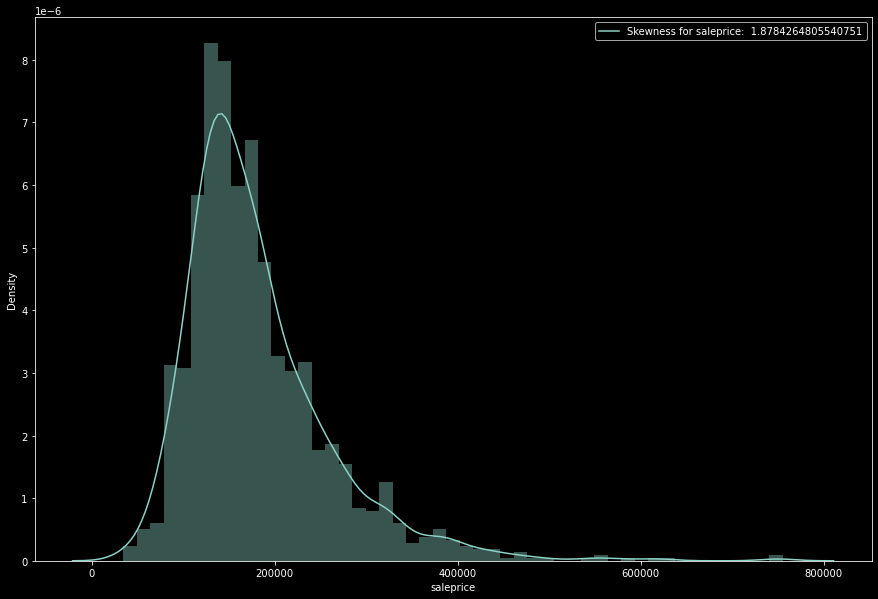

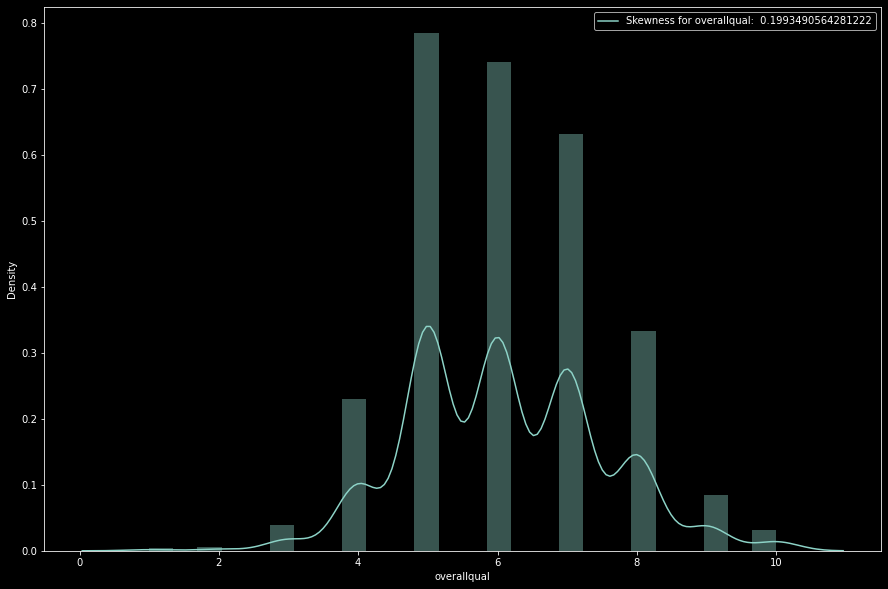

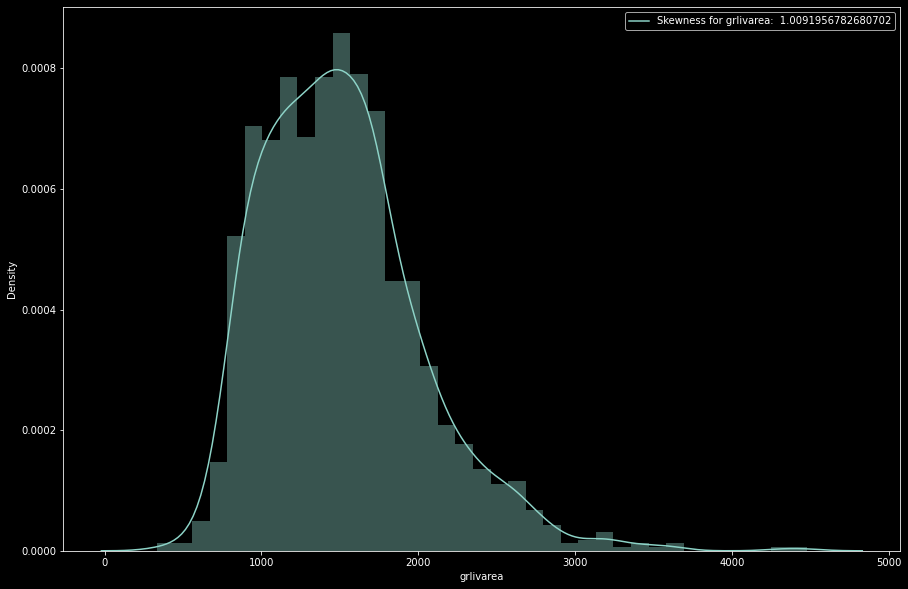

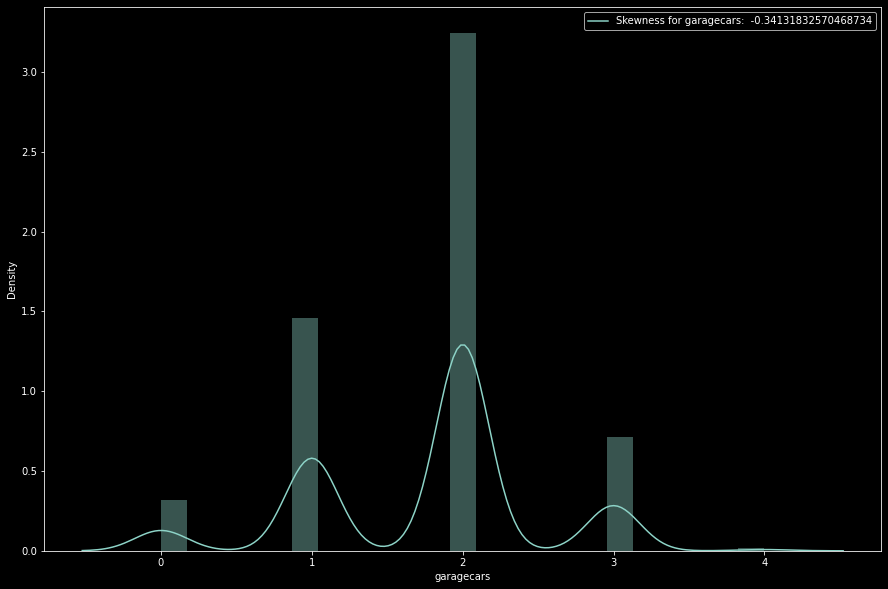

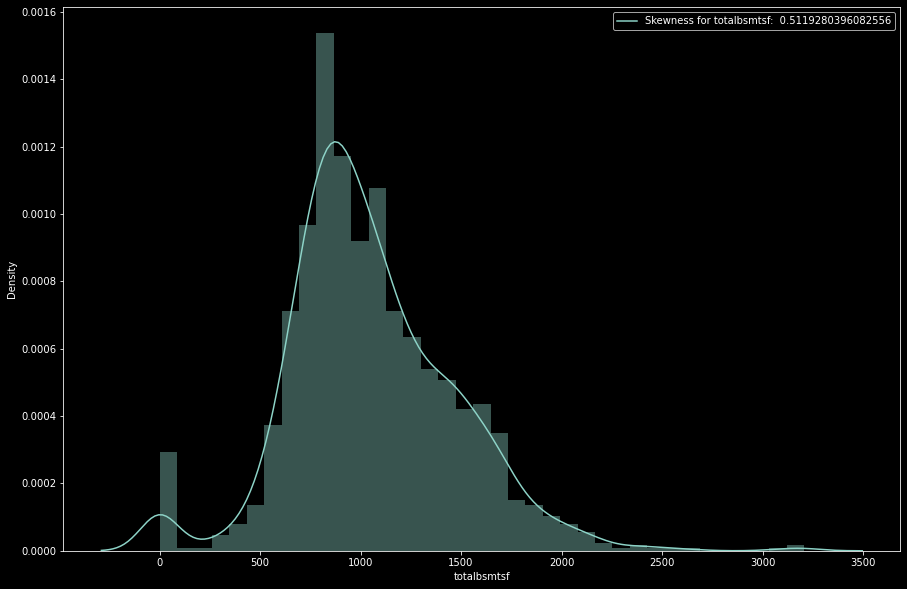

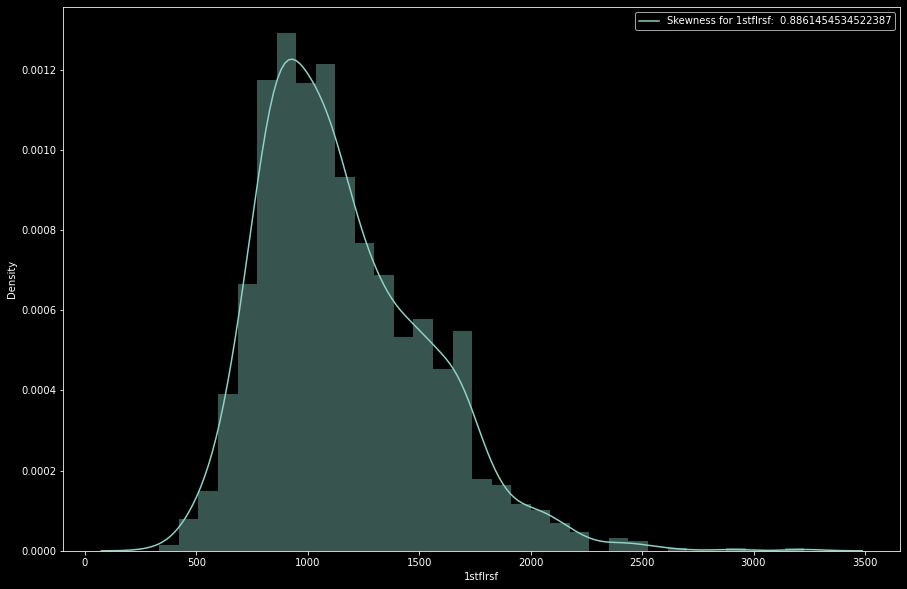

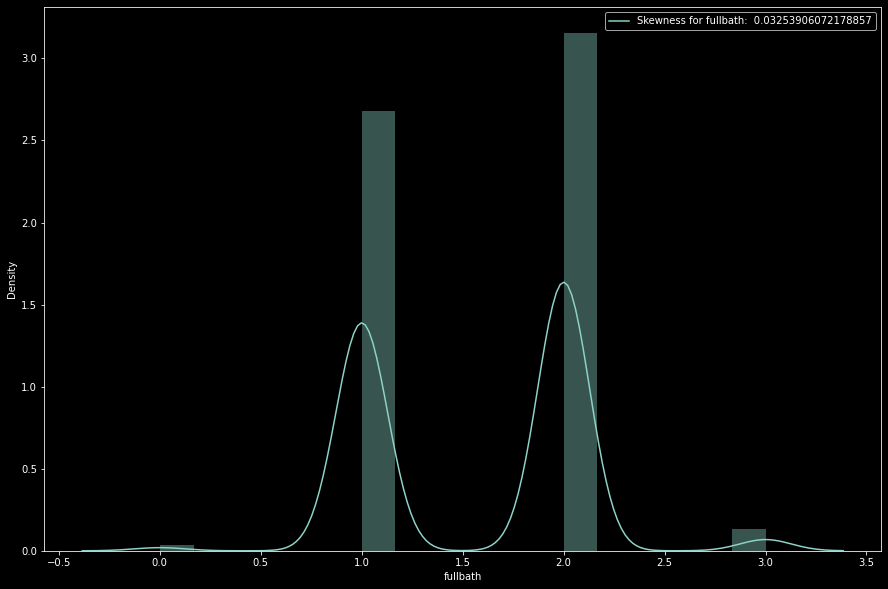

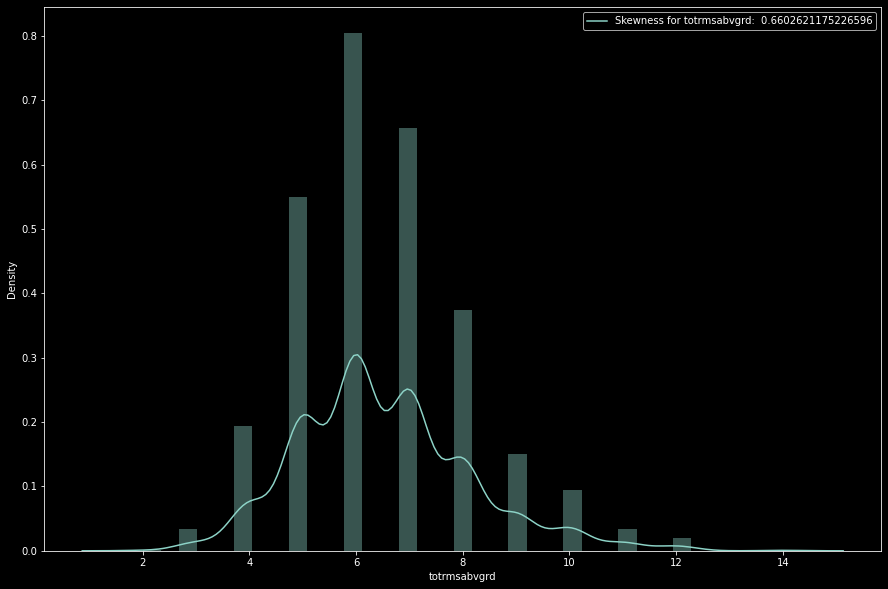

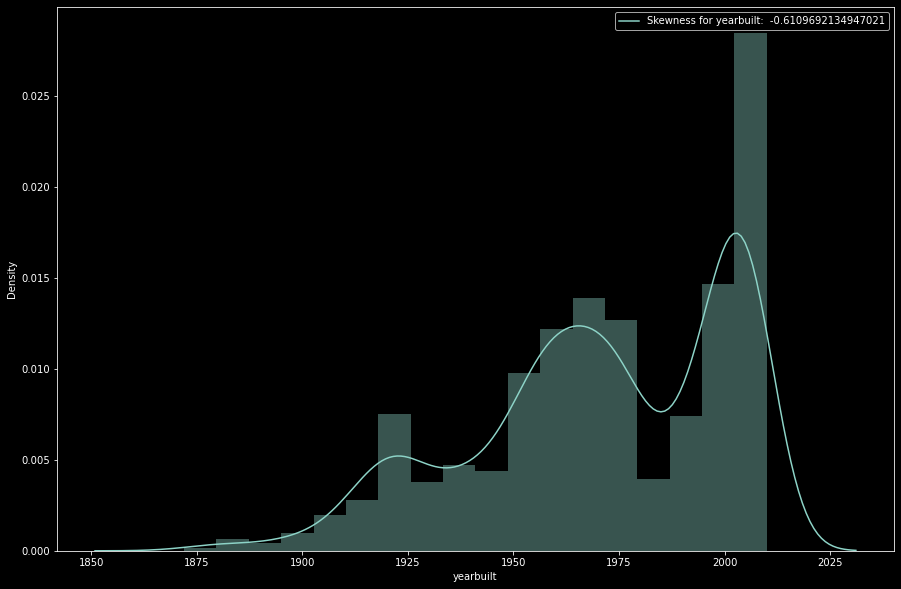

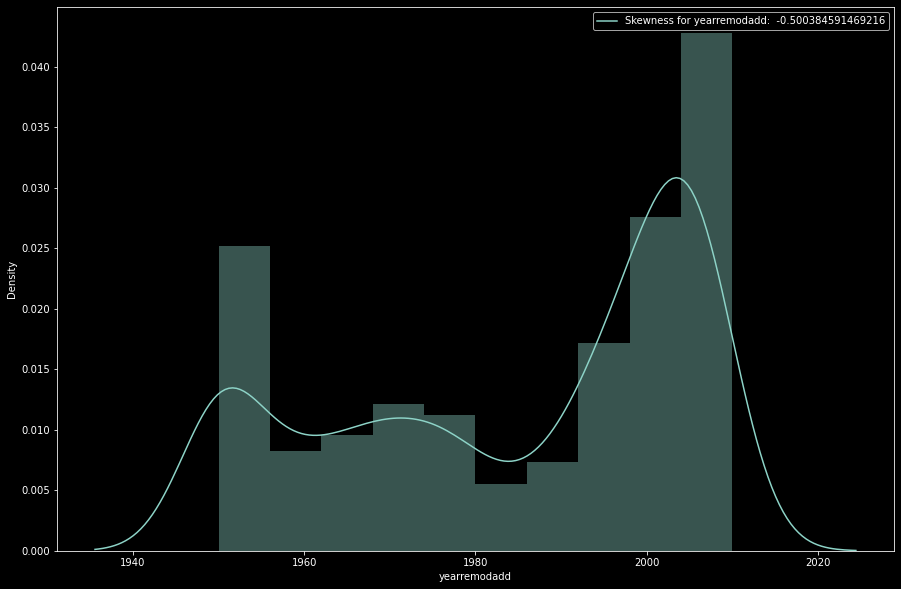

In [24]:
for col in data_corr.columns:
    fig, scatter = plt.subplots(figsize = (15,10))
    hist = sns.distplot(data_corr[col])
    hist.legend([f'Skewness for {col}:  {skew(data_corr[col])}'], )

## Adjusting data

In [25]:
#With cube root, totalbsmtsf gave me -2.9
#With sqrt, data stayed almost the same
#and Log, gave me hopes but...
#totalbsmtsf have values 0 .............

#Fixing totalbsmtsf and columns that have 0
#We need to apply log only if min of column > 0
for col in ['saleprice','grlivarea','totalbsmtsf','1stflrsf']:
    if min(data_adjusted[col]) == 0:
        data_adjusted.loc[data_adjusted[col]>0,col] = data_adjusted[col].apply(np.log)
        print(f'Skewness for {col} (excluding 0s):  {skew(data_adjusted[data_adjusted[col]>0][col])}')
    else:
        data_adjusted[col] = data_adjusted[col].apply(np.log)
            
    skewness = skew(data_adjusted[col])
    print(f'Skewness for {col}:  {skewness}')

Skewness for saleprice:  0.1214258357246035
Skewness for grlivarea:  -0.0718834803307062
Skewness for totalbsmtsf (excluding 0s):  -0.3738073458520752
Skewness for totalbsmtsf:  -5.1670550059353
Skewness for 1stflrsf:  0.004826239996527078


In [26]:
display(data_adjusted)

,saleprice,overallqual,grlivarea,garagecars,totalbsmtsf,1stflrsf,fullbath,totrmsabvgrd,yearbuilt,yearremodadd
id,,,,,,,,,,
1,12.247694,7,7.444249,2,6.752270,6.752270,2,8,2003,2003
2,12.109011,6,7.140453,2,7.140453,7.140453,2,6,1976,1976
3,12.317167,7,7.487734,2,6.824374,6.824374,2,6,2001,2002
4,11.849398,7,7.448334,3,6.628041,6.867974,1,7,1915,1970
5,12.429216,8,7.695303,3,7.043160,7.043160,2,9,2000,2000
...,...,...,...,...,...,...,...,...,...,...
1456,12.072541,6,7.406711,2,6.859615,6.859615,2,7,1999,2000
1457,12.254863,6,7.636752,2,7.340836,7.636752,2,7,1978,1988
1458,12.493130,7,7.757906,1,7.049255,7.080026,2,9,1941,2006


## Visualizing our adjusted data

C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

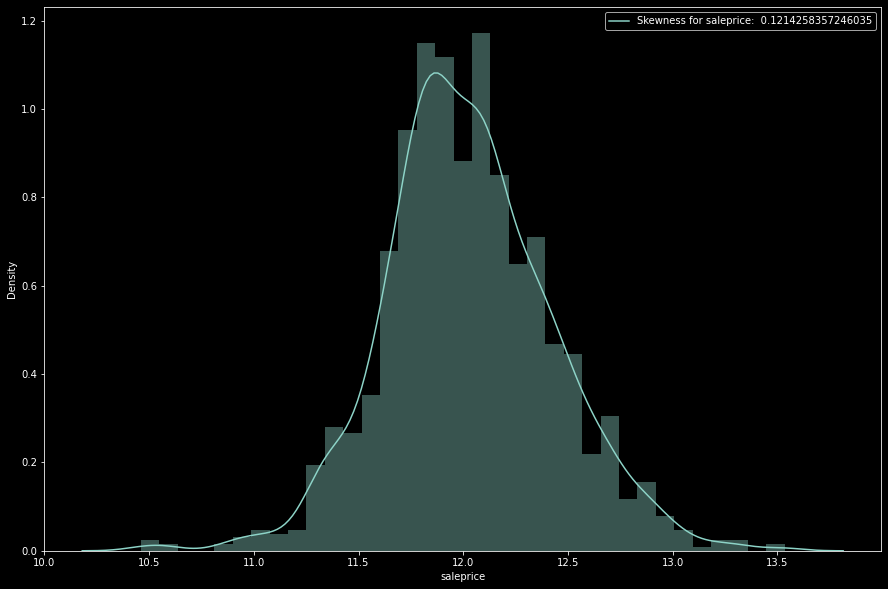

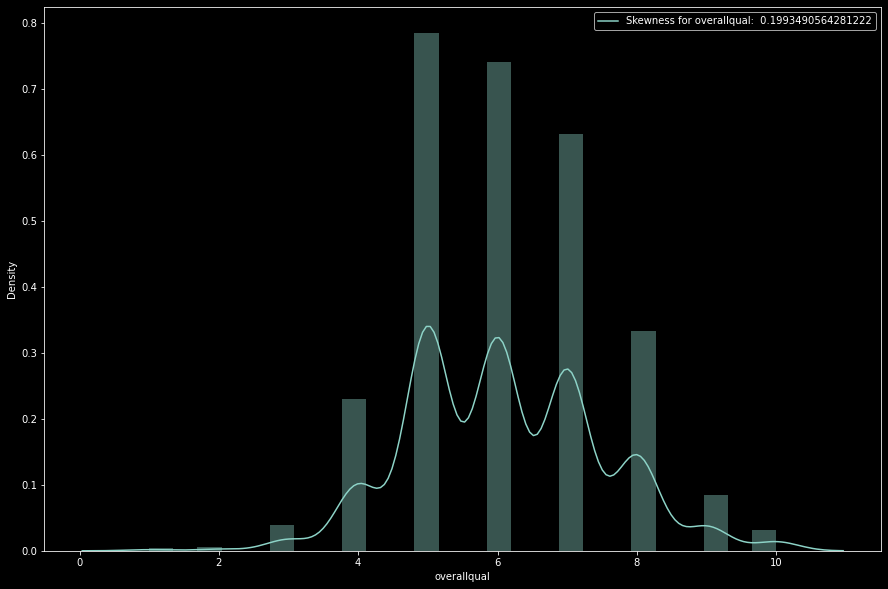

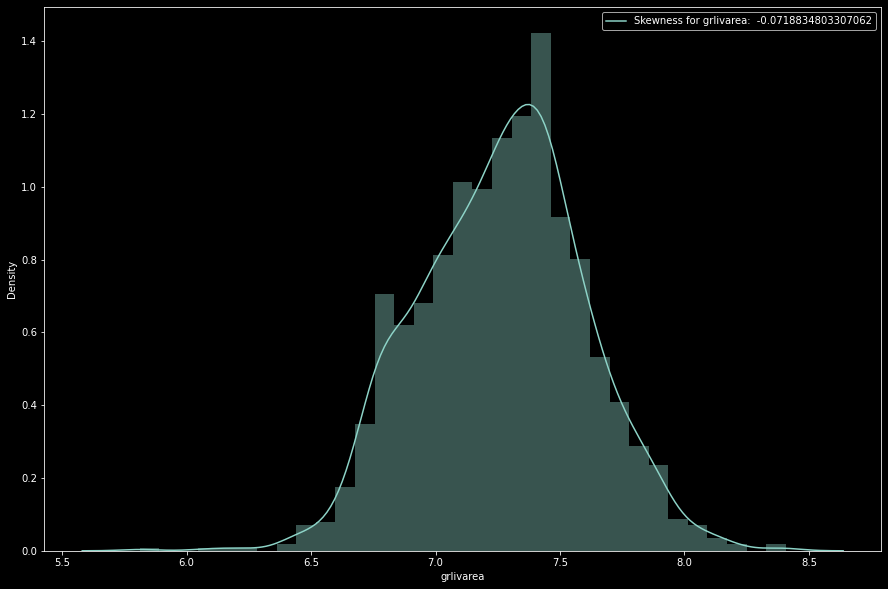

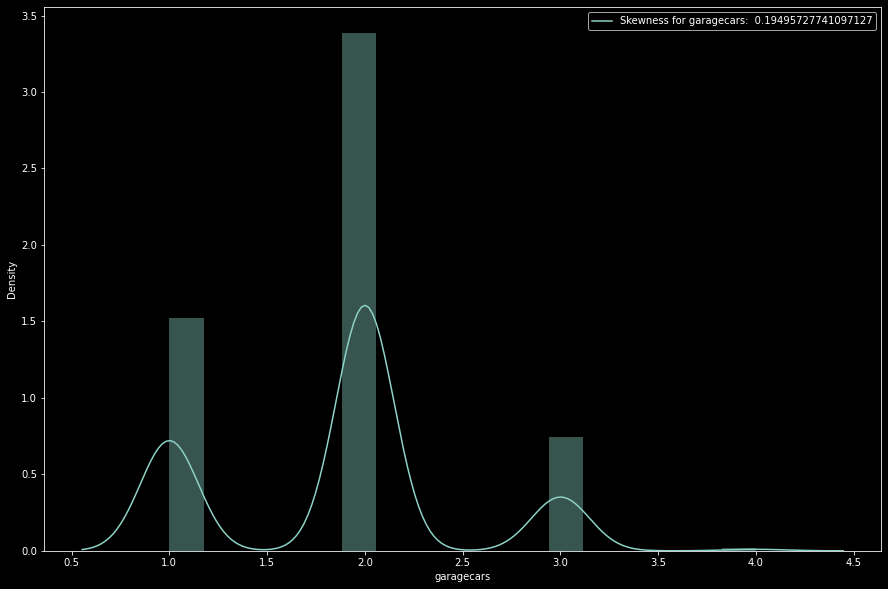

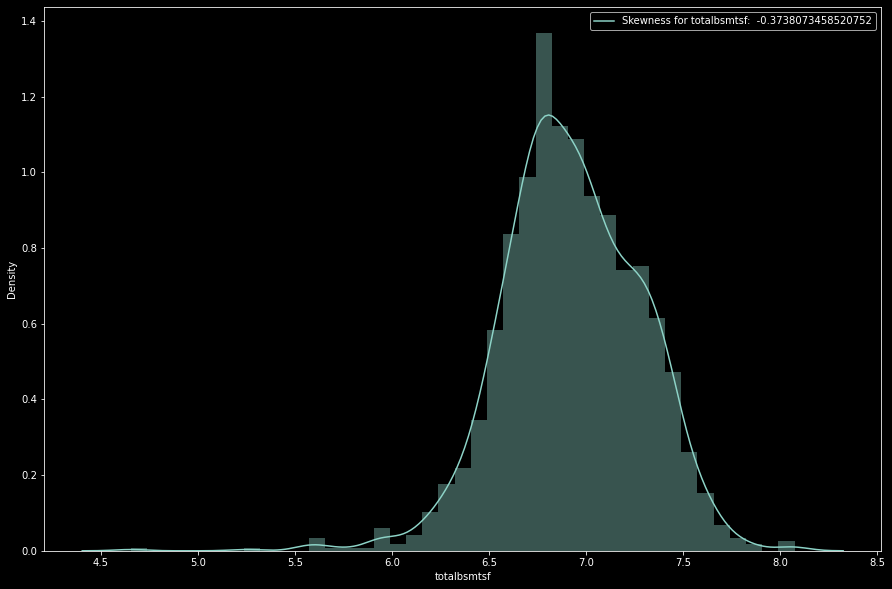

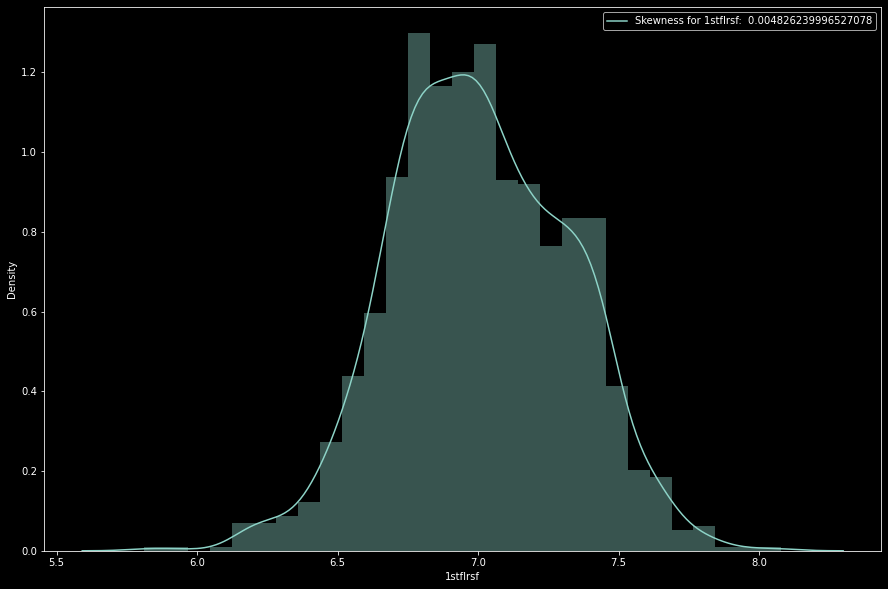

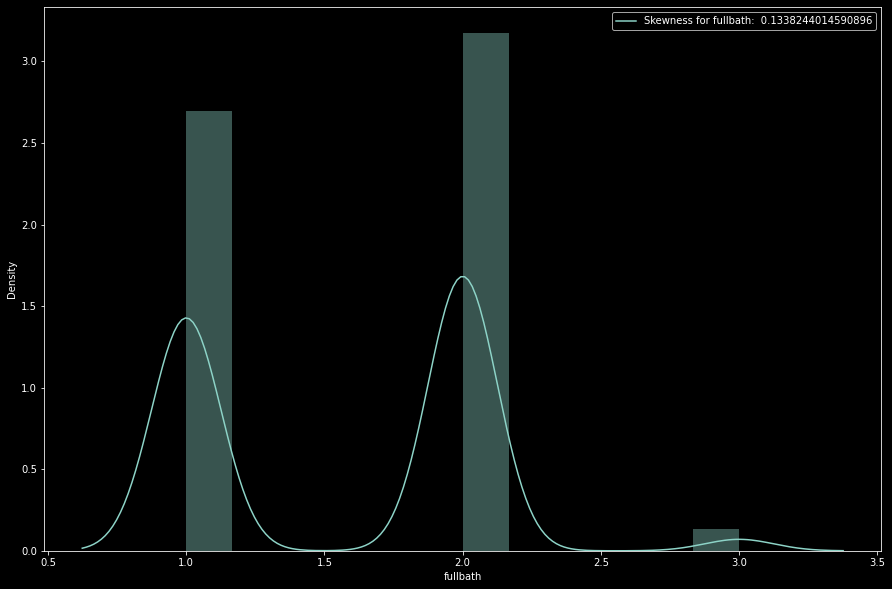

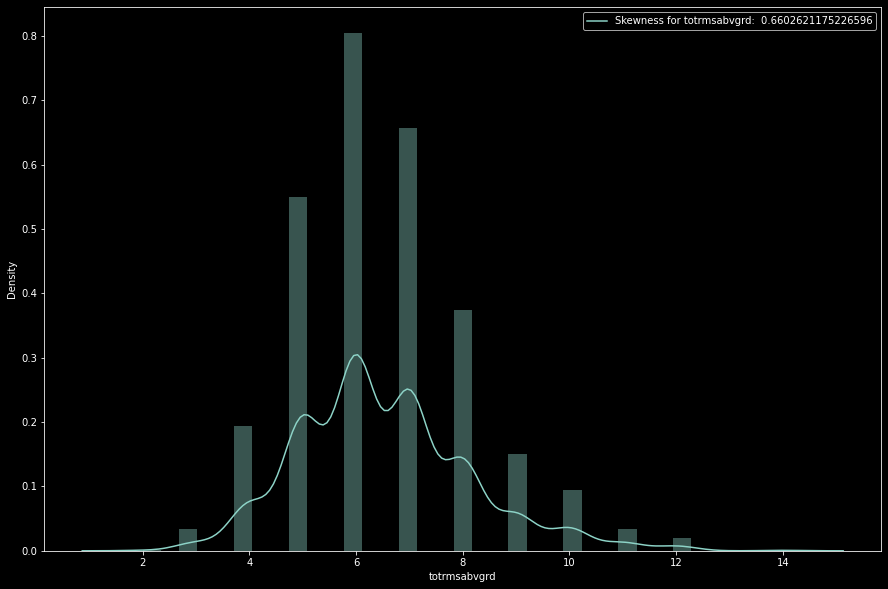

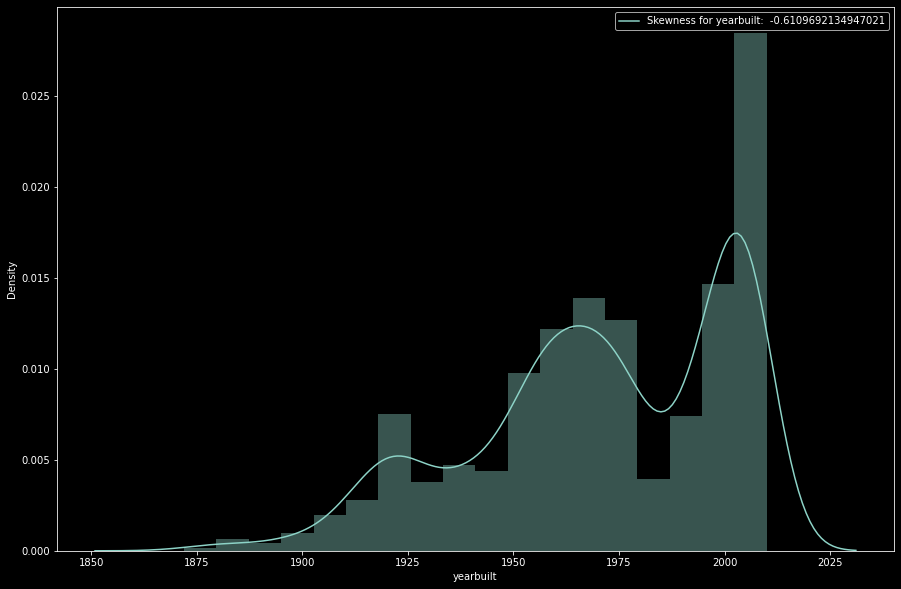

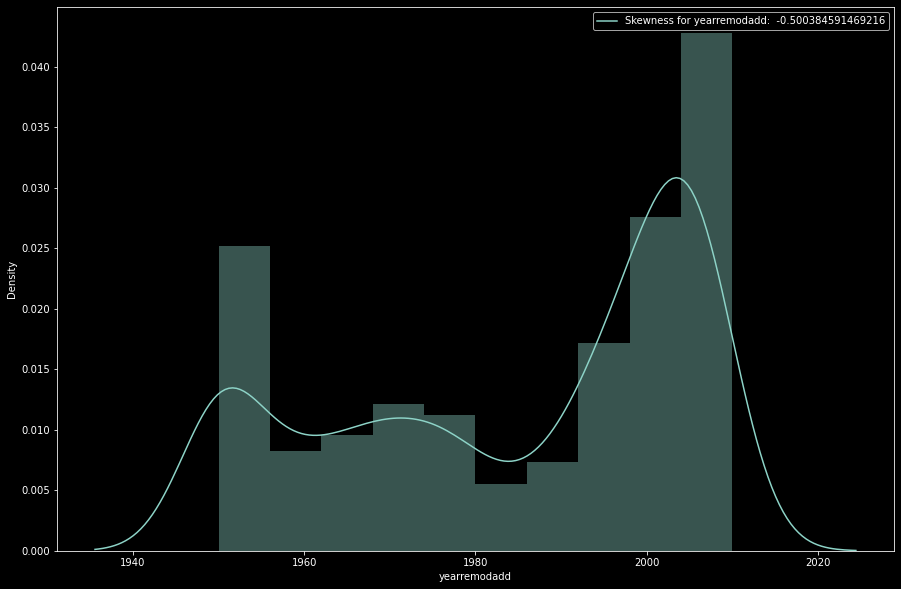

In [27]:
for col in data_adjusted.columns:
    fig, scatter = plt.subplots(figsize = (15,10))
    if min(data_adjusted[col]) == 0:
        d = data_adjusted[data_adjusted[col]>0][col]
        dist = sns.distplot(d)
        dist.legend([f'Skewness for {col}:  {skew(d)}'])
    else:   
        dist = sns.distplot(data_adjusted[col])
        dist.legend([f'Skewness for {col}:  {skew(data_adjusted[col])}'], )

  # Hypothesis Testing

There is a difference in the 'totalbsmtsf' based on 'yearbuilt'. 

$H_0$ = 'totalbsmtsf' doesn't differ by 'yearbuilt' <br>
$H_1$ = 'totalbsmtsf' differ by 'yearbuilt'

if p < 0.05: We reject $H_0$

In [28]:
df_hyptest = data_corr[['totalbsmtsf', 'yearbuilt']]

In [29]:
df_hyptest = df_hyptest.pivot(columns = 'yearbuilt',values='totalbsmtsf')
df_hyptest.fillna(0,inplace=True)

In [30]:
columns = [df_hyptest[col] for col in df_hyptest.columns]
stat,p = f_oneway(*columns)
print(f'p_value: {p}')
if p < 0.05: 
    print(f'We reject 𝐻0 with 95% of certainty and conclude that totalbsmtsf differ by yearbuilt.')
else:
    print(f"We don't reject 𝐻0 with 95% of certainty and conclude that totalbsmtsf is the same in every year")

p_value: 4.960276018866766e-263
We reject 𝐻0 with 95% of certainty and conclude that totalbsmtsf differ by yearbuilt.


------
Cost of the houses with and overallqual > 7 and built after 2000 cost around 300,000

$H_0$ = 300,000<br>
$H_1$ != 300,000

if p < 0.05: We reject $H_0$

In [31]:
df_hyptest = data_corr[['saleprice', 'overallqual', 'yearbuilt']][(data_corr.yearbuilt > 2000)]
df_hyptest = data_corr['saleprice'][(data_corr.overallqual > 7)]

In [32]:
t, p = ttest_1samp(df_hyptest, 300000)
print(f'p_value: {p/2}')
if p/2 < 0.05: 
    print(f'We reject 𝐻0 and conclude that the prices of all the houses built after 2000 and have an overalquall > 7 doesnt cost $300,000.')
else:
    print(f"We don't reject 𝐻0 and conclude that the prices of all the houses built after 2000 and have an overalquall > 7 area around $300,000.")

p_value: 0.16074706151414497
We don't reject 𝐻0 and conclude that the prices of all the houses built after 2000 and have an overalquall > 7 area around $300,000.


--------

$𝐻_0$  = 'grlivarea' doesn't differ when 'overallqual' > 8 <br>
$𝐻_1$  = 'grlivarea' differ when 'overallqual' > 8

if p < 0.05: We reject  𝐻0

In [33]:
df_hyptest = data_corr[['grlivarea','overallqual']][data_corr['overallqual'] > 8]

In [34]:
model = ols('grlivarea ~ C(overallqual)', data=df_hyptest).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]

print(f'p_value: {p}')
if p < 0.05: 
    print(f"We reject 𝐻0 and conclude that 'grlivarea' doesn't differ when 'overallqual' > 8")
else:
    print(f"We don't reject 𝐻0 and conclude that 'grlivarea' differ when 'overallqual' > 8")

p_value: 0.00020151620883552358
We reject 𝐻0 and conclude that 'grlivarea' doesn't differ when 'overallqual' > 8


---

# Linear Regression

In [35]:
#craeating x and y for the linreg model
x = data_adjusted.drop('saleprice', axis=1)
y = data_adjusted.saleprice

#creating test/train datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =.2)

linreg = LinearRegression()
linreg.fit(x_train, y_train)
           
coeff_df = pd.DataFrame(linreg.coef_, x.columns, columns=['Coefficient'])
display(coeff_df)
           
m = linreg.coef_[0]
b = linreg.intercept_
      
predicted = linreg.predict(x_test)
    
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted':predicted})   
display(df_pred)

print(f' y = m * x + b')
print(f' y = {m} * x + {b}')

print("Mean squared error: %.2f" % np.mean((linreg.predict(x_test) -y_test) ** 2))
    
print('Variance score: %.2f' % linreg.score(x_test, y_test)+ "| 1 means perfect prediction")

,Coefficient
overallqual,0.087052
grlivarea,0.419510
garagecars,0.070073
totalbsmtsf,0.029440
1stflrsf,0.201945
fullbath,-0.038818
totrmsabvgrd,-0.000262
yearbuilt,0.002157
yearremodadd,0.002195


,Actual,Predicted
id,,
797,11.874090,12.026654
246,12.394625,12.387105
373,11.736069,11.658396
638,11.440355,11.675789
726,11.699405,11.583862
...,...,...
1169,12.367341,12.132568
796,12.049419,12.010439
689,12.879017,12.376671


 y = m * x + b
 y = 0.08705173096642813 * x + -1.838263721191895
Mean squared error: 0.02
Variance score: 0.85| 1 means perfect prediction


This model is actually really good, we capture 84%~ of the variance of the data. Woo!

# Time Series

I want to show how sales will be between 2010/08-2012/12 month to month

In [36]:
data_clean['yrmosold'] = pd.Series()

<ipython-input-36-d73272cd6561>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_clean['yrmosold'] = pd.Series()


In [37]:
for n in range(len(data_clean['yrsold'])):
    year = data_clean['yrsold'].iloc[n]
    month = data_clean['mosold'].iloc[n]
    if month < 10:
        data_clean['yrmosold'].iloc[n] = np.datetime64(f'{str(year)}-0{str(month)}')
    else:
        data_clean['yrmosold'].iloc[n] = np.datetime64(f'{str(year)}-{str(month)}')

C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [38]:
data_clean['yrmosold']

0       2008-02
1       2007-05
2       2008-09
3       2006-02
4       2008-12
         ...   
1455    2007-08
1456    2010-02
1457    2010-05
1458    2010-04
1459    2008-06
Name: yrmosold, Length: 1457, dtype: object

In [39]:
sales = data_clean[['yrmosold','saleprice']]

sales= sales.groupby(['yrmosold'],as_index=True).sum()

In [40]:
#Resampling
y = sales['saleprice'].resample('MS').mean()

<AxesSubplot:xlabel='yrmosold'>

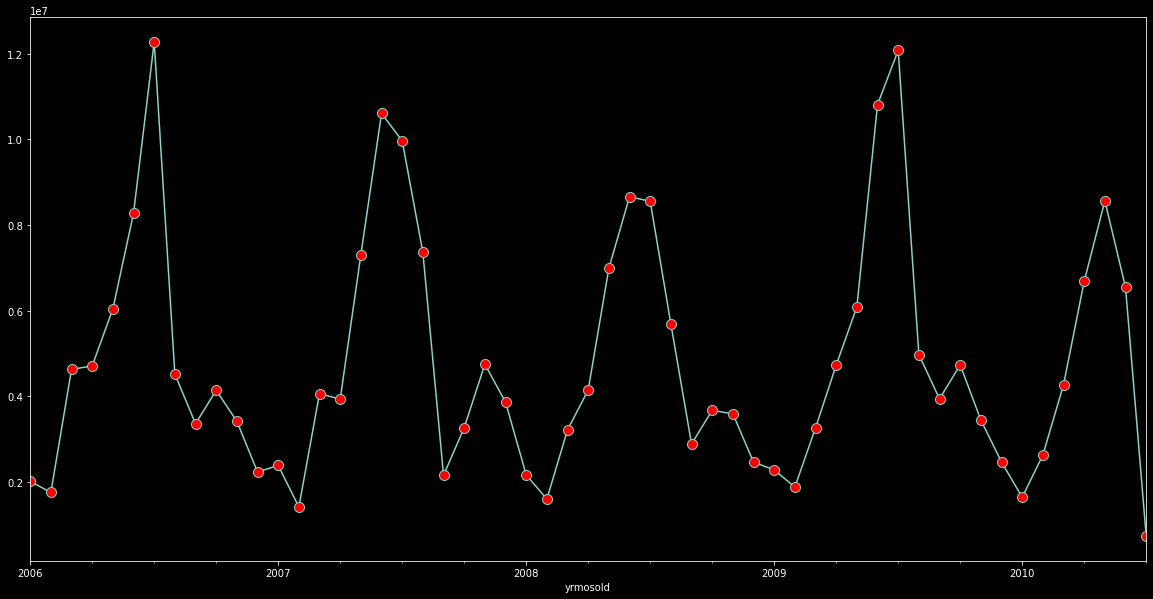

In [41]:
plt.style.use('dark_background')
y.plot(figsize=(20,10),marker="o",markersize=10,markerfacecolor='red')

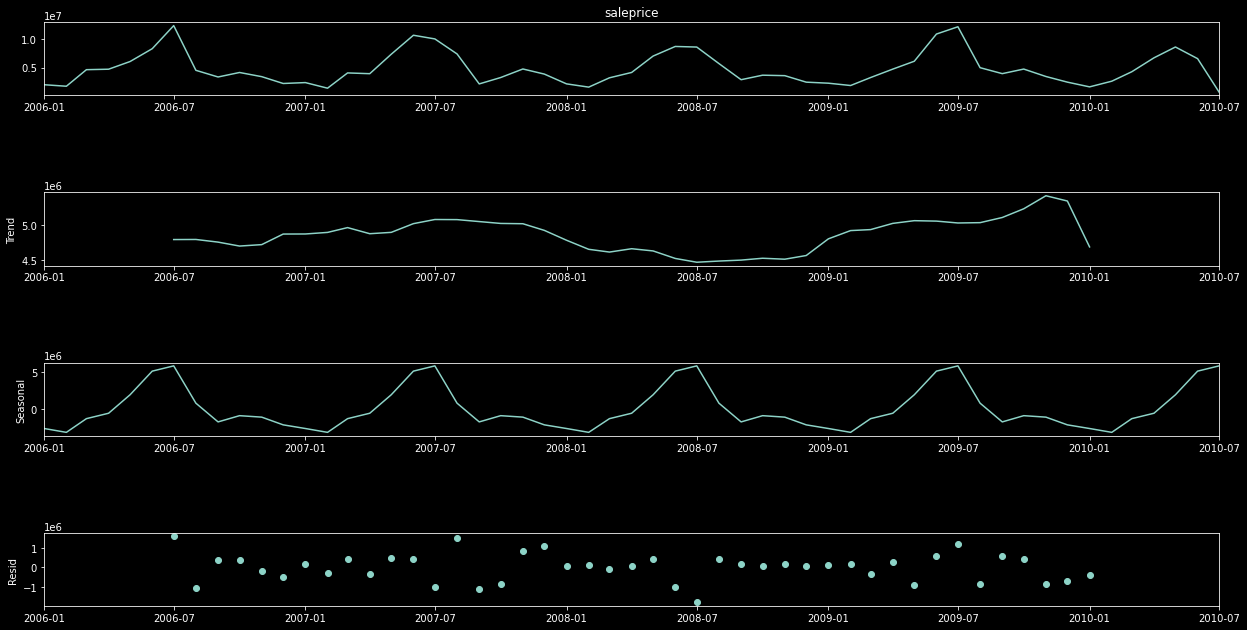

In [42]:
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig = decomposition.plot()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.show()

In [43]:
#H_0 Stationary data
#H_1 Non stationary data

dftest = adfuller(data_clean['saleprice'],autolag=None)

print(f'Prueba estadistica {dftest[0]}')
print(f'P-value  {dftest[1]}')
for k, v in dftest[4].items():
    print('\t{}:{} Data is {}. {}% sure'.format(k, v, "non stationary" if v < dftest[0] else "stationary", 100-int(k[:-1])))


Prueba estadistica -7.915873585932024
P-value  3.837678142418311e-12
	1%:-3.4349247631306237 Data is stationary. 99% sure
	5%:-2.8635604442944658 Data is stationary. 95% sure
	10%:-2.5678456715029183 Data is stationary. 90% sure


In [51]:
p = d = q =range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
temp = 10000000

for param in pdq:
    for s_param  in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=s_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            aic = results.aic          
            if aic < temp:
                temp = aic
                p= param
                s_p =s_param
                print(f'ARIMA {param} x {s_param}12 - AIC:{aic}')
                
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 - AIC:1833.4227411746465
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 - AIC:1402.4710825476795
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 - AIC:1353.2444869084557
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 - AIC:989.8379068430382
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 - AIC:961.8505257306166
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 - AIC:961.6128304515123
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 - AIC:933.1672727669592


In [52]:
mod = sm.tsa.statespace.SARIMAX(y,order=(p),seasonal_order=(s_p),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

In [53]:
predictions = results.get_prediction(start=pd.to_datetime('2009-01-01'),end= pd.to_datetime('2010-07-01'))
pred_ci = predictions.conf_int()

In [54]:
pred_ci

,lower saleprice,upper saleprice
yrmosold,,
2009-01-01,-3.188013e+06,6.048264e+06
2009-02-01,-2.908733e+06,6.327544e+06
2009-03-01,-6.799826e+05,8.556294e+06
2009-04-01,-9.418294e+05,8.294447e+06
2009-05-01,3.322696e+06,1.255897e+07
2009-06-01,3.437041e+06,1.267332e+07
2009-07-01,6.340250e+06,1.557653e+07
2009-08-01,4.976696e+06,1.421297e+07
2009-09-01,-4.147124e+06,5.089152e+06


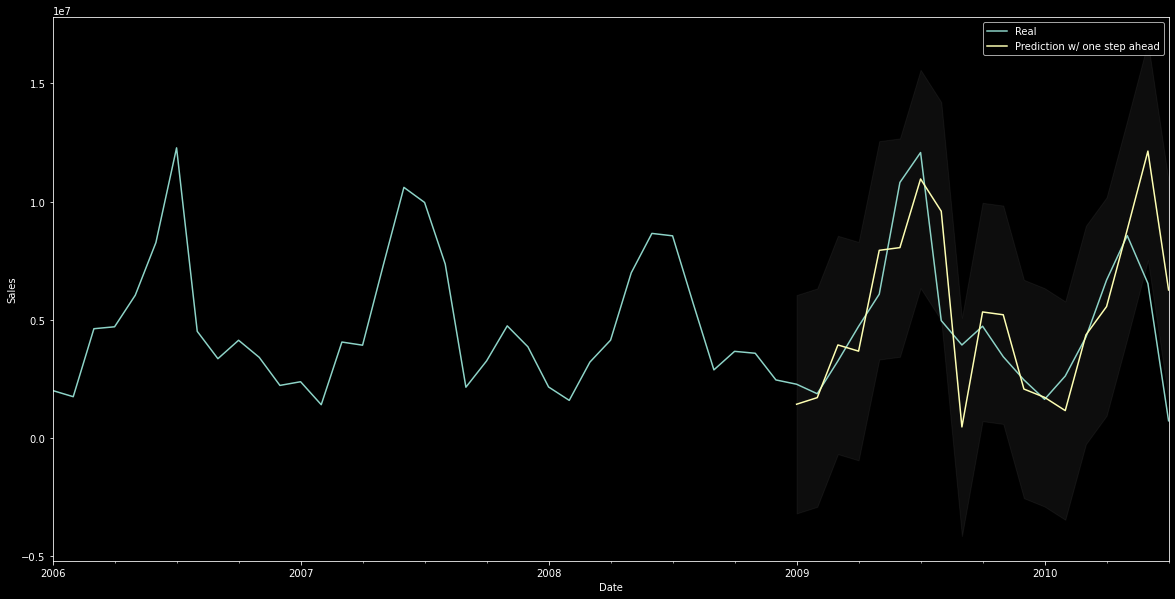

In [55]:
ax = y['2006':].plot(label='Real')
predictions.predicted_mean.plot(ax=ax, label='Prediction w/ one step ahead', alpha=1, figsize=(20,10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='gray',
                alpha=0.1)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

We're not that far

## Let's explore the unknown

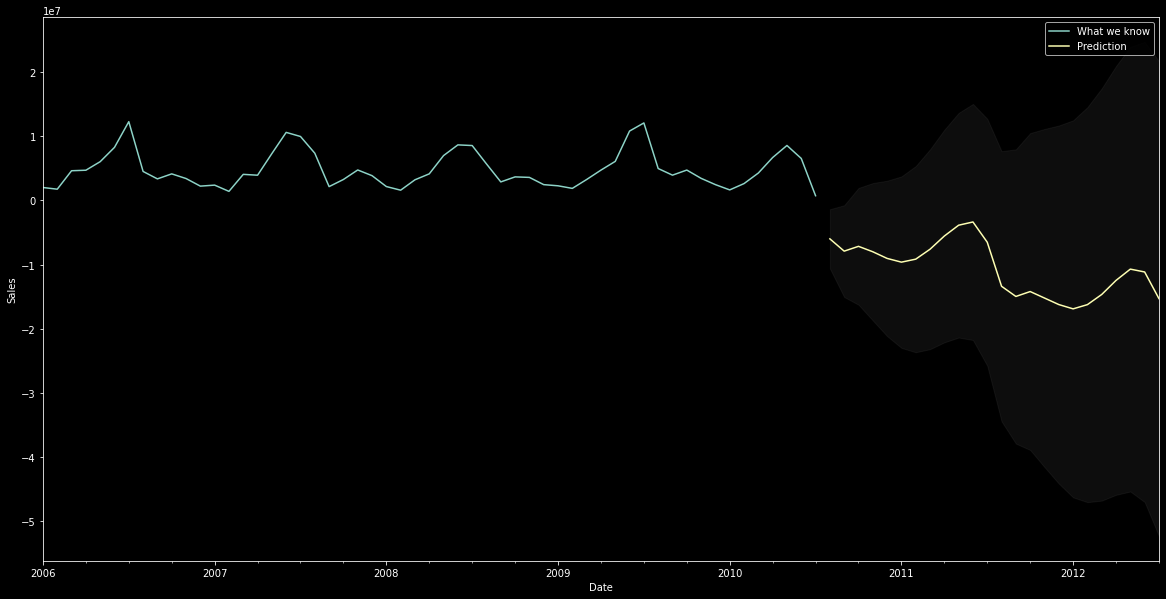

In [56]:
future = results.get_forecast(steps=24)
pred_ci = future.conf_int()
ax = y.plot(label='What we know', figsize=(20,10))
future.predicted_mean.plot(ax=ax, label='Prediction')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0], #lower saleprice
                pred_ci.iloc[:,1], #upper saleprice
                color='gray',
                alpha=0.1)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Docs:

https://www.geeksforgeeks.org/scipy-stats-skew-python/

https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55#:~:text=If%20skewness%20value%20lies%20above%20%2B1%20or%20below,whether%20it%20is%20positively%20skewed%20or%20negatively%20skewed.

https://tutorials.technology/tutorials/19-how-to-do-a-regression-with-sklearn.html

https://365datascience.com/linear-regression/

https://courses.lumenlearning.com/introstats1/chapter/distribution-needed-for-hypothesis-testing/

https://www.rapidtables.com/math/algebra/logarithm/Logarithm_of_0.html

https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55#:~:text=If%20skewness%20value%20lies%20above%20%2B1%20or%20below,whether%20it%20is%20positively%20skewed%20or%20negatively%20skewed.

https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45

https://towardsdatascience.com/violin-plots-explained-fb1d115e023d#:~:text=In%20general%2C%20violin%20plots%20are%20a%20method%20of,%28the%20black%20bar%20in%20the%20center%20of%20violin%29